# README
# BERT-based Text Classification / 基于BERT的文本分类 

## 项目概述 / Project Overview
- 本项目并非作者原创 / This project is not original by the author.  
  Forked from [Git repository](https://github.com/wxxxuser/aliyuntianchi-ncaa2024), Author: wxxuer.
  
- 旨在学习与课程训练，在原仓库的基础上修改与合并，使得项目更条理清晰 / This project aims to learn and train for the course, with modifications and merges on the original repository to make the project more organized.  

- Modified by: bebopoy, Email: xiangtongnie@gmail.com.  联系方式用于错误勘正

## Overview / 概述
This Jupyter Notebook demonstrates a BERT-based approach for text classification, where we apply BERT to classify text data. The notebook covers the entire process, from loading and preprocessing data, to tokenization, model training, and evaluation.  
本Jupyter笔记本演示了基于BERT的文本分类方法，利用BERT进行文本数据的分类。该笔记本涵盖了从数据加载与预处理、分词、模型训练到评估的完整过程。

## Libraries & Tools Used / 使用的库与工具
- **BERT (Bidirectional Encoder Representations from Transformers)**: A transformer-based model pre-trained on a large corpus of text and fine-tuned for specific NLP tasks.  
  **BERT（双向编码器表示的变换器）**：一种基于变换器的模型，预先训练于大规模文本语料库，并针对特定的NLP任务进行微调。
- **PyTorch**: A deep learning framework used for model training and optimization.  
  **PyTorch**：用于模型训练和优化的深度学习框架。
- **HuggingFace Transformers**: A library for state-of-the-art NLP models, providing easy access to BERT.  
  **HuggingFace Transformers**：一个用于最新NLP模型的库，提供对BERT等模型的便捷访问。
- **Scikit-learn**: Used for evaluation metrics and data handling.  
  **Scikit-learn**：用于评估指标和数据处理。

## Steps Covered in the Notebook / 笔记本中涵盖的步骤
1. **Data Loading and Preprocessing / 数据加载与预处理**:
   - Loading data from `.txt` files, which contain text data (questions) and corresponding labels.  
     从`.txt`文件加载数据，其中包含文本数据（问题）和相应的标签。
   - Tokenizing the text using BERT's tokenizer.  
     使用BERT的分词器对文本进行分词。

2. **Model Setup / 模型设置**:
   - Defining the BERT-based model, including various layers for feature extraction and classification.  
     定义基于BERT的模型，包括用于特征提取和分类的各种层。
   - Implementing a custom attention mechanism and LSTM layers.  
     实现自定义的注意力机制和LSTM层。

3. **Model Training / 模型训练**:
   - Training the BERT-based model on the dataset.  
     在数据集上训练基于BERT的模型。
   - Experimenting with techniques such as adversarial training (FGM) and R-Drop regularization.  
     尝试使用对抗训练（FGM）和R-Drop正则化等技术。

4. **Evaluation / 评估**:
   - Evaluating the model on a validation set using accuracy and other metrics.  
     使用准确率和其他评估指标在验证集上评估模型。

5. **Prediction and Submission / 预测与提交**:
   - Making predictions on the test set and preparing the results for submission.  
     在测试集上进行预测并准备提交结果。

## About the topic / 关于题目

- 天池大数据竞赛 NCAA2024-中文糖尿病问题分类 notebook
- 数据来源 课程自用


# CODE IN LIB

## 导入库

In [1]:
import sklearn
import transformers
import torch

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 数据预处理

### 加载数据

In [3]:
from transformers import BertTokenizer
import pandas as pd

def load_data(file_path):
    # 加载数据
    df = pd.read_csv(file_path, delimiter='\t', header=None, names=['question', 'label'])
    input_data = df['question'].tolist()
    labels = df['label'].tolist()
    return input_data, labels

# data 是问题列表，labels 是标签列表
train_data, train_labels = load_data('data/train.txt')
dev_data, dev_labels = load_data('data/dev.txt')
test_data, _ = load_data('data/test.txt')  # 测试集可能没有标签


In [4]:
train_data[0], train_labels[0]

('空腹血糖78，是否属于糖尿病范围?', 0)

### 分词与编码

In [5]:
# 返回tokenized后的数据,数字化
def tokenize(input_data):
    # 加载分词器（Tokenizer）
    tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
    # 分词与编码
    encoded_input = tokenizer(input_data, padding=True, truncation=True, max_length=25, return_tensors='pt').to(device)
    return encoded_input

# 对训练集、验证集和测试集进行分词
encoded_train = tokenize(train_data)
encoded_dev = tokenize(dev_data)
encoded_test = tokenize(test_data)

In [6]:
# 查看第一个句子的词汇表索引及 Token
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
encoded_train['input_ids'][0], tokenizer.decode(encoded_train['input_ids'][0])

(tensor([ 101, 4958, 5592, 6117, 5131, 8409, 8024, 3221, 1415, 2247,  754, 5131,
         2228, 4567, 5745, 1741,  136,  102,    0,    0,    0,    0,    0,    0,
            0], device='cuda:0'),
 '[CLS] 空 腹 血 糖 78 ， 是 否 属 于 糖 尿 病 范 围? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]')

## 向量表示

### 获取BERT隐藏层的输出

In [7]:
from transformers import BertModel

def bert_hidden_states(model, encoded_data):

    model.to(device)
    # model.eval()

    # text = "空腹血糖5.8是否偏高?"
    hidden_states = []
    indexed_tokens = encoded_data  # 获取ids序列，即词汇表索引
    # print(indexed_tokens)
    # for tokens in encoded_data:
        # tokens_tensor = torch.tensor([indexed_tokens]).to(device) # 将输入转化为torch的tensor
    with torch.no_grad(): # 获取该句子在BERT模型中的隐藏层输出，禁用梯度计算，因为只是前向传播获取隐藏层状态，所以不需要计算梯度
        hidden_states = model(**indexed_tokens)
    # print(hidden_states[2])

    return hidden_states

c:\Users\Nxt03\anaconda3\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\Nxt03\anaconda3\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: h

In [8]:
encoded_train_part = {'input_ids': encoded_train['input_ids'][0:10], 'token_type_ids': encoded_train['token_type_ids'][0:10], 'attention_mask': encoded_train['attention_mask'][0:10]}
encoded_train_part['input_ids']

tensor([[ 101, 4958, 5592, 6117, 5131, 8409, 8024, 3221, 1415, 2247,  754, 5131,
         2228, 4567, 5745, 1741,  136,  102,    0,    0,    0,    0,    0,    0,
            0],
        [ 101, 1121, 5503, 1400, 3221, 1415, 5543, 3121, 1587, 5131, 2228, 4567,
         4307, 1105,  136,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 101, 2642, 3300, 5131, 2228, 4567, 4638, 3678,  779, 5445, 4266,  779,
         3766, 3300, 8024, 3221, 1415,  833, 6890,  837, 5314,  678,  671,  807,
          102],
        [ 101, 5131, 2228, 4567, 3221, 1415,  833, 2471, 6629, 4706, 4714, 3717,
         5514,  136,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 101, 1969, 2027, 3309, 5131, 2228, 4567, 4638, 3800, 2692,  752, 7555,
         3221,  784,  720,  136,  102,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 101, 5131, 2228, 4567, 2642, 5442, 3221, 1415, 1377,  809, 4500, 1054,
         1346, 3796, 3717, 16

In [9]:
model = BertModel.from_pretrained('bert-base-chinese', output_hidden_states=True)  # 预训练的BERT模型
train_hidden_states = bert_hidden_states(model, encoded_train_part)
print(train_hidden_states)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.6100,  0.2591,  0.6507,  ...,  0.7955, -0.1444,  0.7125],
         [ 0.1590,  0.1049,  0.8231,  ..., -0.0797, -0.8196,  0.3255],
         [ 1.3088, -0.5571, -1.4698,  ...,  1.6311, -0.3295,  0.9840],
         ...,
         [ 0.3002,  0.1296, -0.1095,  ..., -0.0978, -0.3316,  0.2508],
         [ 0.3744, -0.4559, -0.0358,  ...,  0.1019, -0.0421,  0.1730],
         [ 0.4220, -0.6914, -0.0336,  ...,  0.2508,  0.0890,  0.4385]],

        [[ 0.1640,  0.8354,  0.0594,  ...,  0.2457,  0.1447,  0.0091],
         [-0.3491,  1.4873, -0.3473,  ..., -0.0766, -0.2133, -0.1140],
         [ 0.2505,  0.8064, -0.9210,  ...,  1.3393,  0.8358,  0.2127],
         ...,
         [ 0.1854, -0.2916, -0.3698,  ..., -0.0061, -0.0727, -0.0253],
         [ 0.3748, -0.0451, -0.2638,  ...,  0.3145, -0.0660, -0.0221],
         [ 0.5144,  0.1843, -0.3248,  ...,  0.4232, -0.1127, -0.0787]],

        [[ 0.8068,  0.0423, -0.5351,  ..., -0.1710,  

In [10]:
train_hidden_states['hidden_states'][-1].shape

torch.Size([10, 25, 768])

### 句子的向量表示 （对bert的隐层操作）

#### 取BERT第3, 6, 9, 12层的第一个token对应的向量

In [11]:
def vector1(hidden_states):
    vectors = []

    for layer in [hidden_states[3], hidden_states[6], hidden_states[9], hidden_states[12]]:
        layer_vectors = []
        for state in layer:
            layer_vectors.append(state[0])
        layer_vectors = torch.stack(layer_vectors, dim=0)
        vectors.append(layer_vectors)

    # print(vectors)
    return torch.cat(vectors, dim=1)  # 将四个向量并成一个向量

#### 取BERT最后四层的第一个token对应的向量进行融合

In [13]:
def vector2(hidden_states):
    vectors = []

    for layer in hidden_states[-4:]:
        layer_vectors = []
        for state in layer:
            layer_vectors.append(state[0])
        layer_vectors = torch.stack(layer_vectors, dim=0)
        vectors.append(layer_vectors)

    # print(vectors)
    return torch.cat(vectors, dim=1)  # 将四个向量并成一个向量

#### 取BERT最后四层第一个token对应的向量进行最大池化

In [14]:
def vector3(hidden_states):
    vectors = []

    for layer in hidden_states[-4:]:
        layer_vectors = []
        for state in layer:
            layer_vectors.append(state[0])
        layer_vectors = torch.stack(layer_vectors, dim=0)
        vectors.append(layer_vectors)

    # print(torch.max(torch.stack(vectors), dim=0))
    return torch.max(torch.stack(vectors), dim=0).values  # 将四个向量并成一个向量

#### 取BERT最后一层第一个和最后一个token对应的向量进行融合

In [15]:
def vector4(last_hidden_state):
    vectors = []

    for state in last_hidden_state:
        combine_tokens = (state[0] + state[-1]) / 2
        vectors.append(combine_tokens)
        # print(vectors)

    return torch.stack(vectors, dim=0)

#### 拼接最后一层隐藏层所有token的向量

In [16]:
def vector5(last_hidden_state):
    vectors = []

    for state in last_hidden_state:
        combine_tokens = []
        for token in state:
            combine_tokens.append(token)
        combine_tokens = torch.concat(combine_tokens)
        vectors.append(combine_tokens)
        # print(vectors)

    return torch.stack(vectors, dim=0)

In [17]:
x = torch.zeros_like(train_hidden_states['hidden_states'][-1])
for tensor in train_hidden_states['hidden_states'][-4:]:
    x += tensor
x.shape

torch.Size([10, 25, 768])

In [18]:
vector5(train_hidden_states['last_hidden_state']).shape

torch.Size([10, 19200])

### 定义模型架构 （对bert的隐层操作）

#### 双向LSTM-Attention层

In [25]:
import torch
import torch.nn as nn

class LSTMAttention(torch.nn.Module):
    def __init__(self, hidden_size, classifier_dropout, num_labels=6, lstm_layers=1):
        super(LSTMAttention, self).__init__()

        # 双向LSTM层
        # input_size: 输入特征的维度，这里与hidden_size相同
        # hidden_size: LSTM隐藏层的维度
        # num_layers: LSTM的层数
        # bidirectional: 是否使用双向LSTM
        # batch_first: 输入数据的第一个维度是否为batch size
        self.lstm = torch.nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                                  num_layers=lstm_layers,
                                  bidirectional=True, batch_first=True)

        # 注意力机制层
        # 输入维度为hidden_size * 2（因为LSTM是双向的，输出维度为hidden_size * 2）
        # 输出维度为1，用于计算注意力权重
        self.attention = torch.nn.Linear(hidden_size * 2, 1)

        # Dropout层，用于防止过拟合
        self.dropout = nn.Dropout(classifier_dropout)

        # 全连接层，用于分类
        # 输入维度为hidden_size * 2（双向LSTM的输出）
        # 输出维度为num_labels，即分类的类别数
        self.fc = torch.nn.Linear(hidden_size * 2, num_labels)  # 双向故乘以2

    def forward(self, hidden_states, dropout):
        # LSTM层的前向传播
        # lstm_out: LSTM的输出，形状为(batch_size, sequence_length, hidden_size * 2)
        # _: LSTM的隐藏状态和细胞状态，这里不需要使用
        lstm_out, _ = self.lstm(hidden_states)

        # 注意力机制的前向传播
        # attn_weights: 注意力权重，形状为(batch_size, sequence_length, 1)
        # 使用softmax函数将注意力权重归一化，使得权重之和为1
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)

        # 计算加权后的输出
        # attn_output: 加权后的输出，形状为(batch_size, hidden_size * 2)
        # 使用矩阵乘法将lstm_out与注意力权重相乘，得到加权后的输出
        attn_output = torch.bmm(lstm_out.transpose(1, 2), attn_weights).squeeze(2)

        # 如果dropout为True，则对加权后的输出应用dropout
        if dropout == True:
            attn_output = self.dropout(attn_output)

        # 分类层的前向传播
        # out: 最终的分类输出，形状为(batch_size, num_labels)
        out = self.fc(attn_output)
        return out

#### TextCNN

In [19]:
import torch
import torch.nn as nn
from transformers import BertModel

class TextCNN(nn.Module):
    def __init__(self, hidden_size, classifier_dropout, num_labels=6, num_filters=256, filter_sizes=[2,3,4]):
        super(TextCNN, self).__init__()
        self.convs = nn.ModuleList(
            [nn.Conv2d(1, num_filters, (k, hidden_size)) for k in filter_sizes]
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_labels)

    def forward(self, hidden_states, dropout):

        x = torch.zeros_like(hidden_states[-1])
        for tensor in hidden_states[-3:]:
            x += tensor
        x = x.unsqueeze(1)  # 维度：(batch_size, 1, max_length, hidden_size)

        # TextCNN层
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]  # 维度：[(batch_size, num_filters, max_length-filter_size+1)] * len(filter_sizes)
        x = [nn.functional.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # 维度：[(batch_size, num_filters)] * len(filter_sizes)
        x = torch.cat(x, 1)  # 维度：(batch_size, num_filters * len(filter_sizes))

        if dropout == True:
            x = self.dropout(x)
        # 分类
        logits = self.fc(x)
        return logits

## 定义Bert网络结构

In [20]:
import torch.nn.functional as F

class BertClassifier(torch.nn.Module):
    def __init__(self, vector_type='last_four_layers_first_token', classifier_dropout=0.1, num_labels=6):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-chinese', output_hidden_states=True)  # 加载预训练的BERT模型
        self.vector_size = self.bert.config.hidden_size  # 词向量大小
        self.vector_type = vector_type  # 词向量类型
        self.dropout = torch.nn.Dropout(classifier_dropout)  # Dropout层，防止过拟合，提高泛化能力
        self.classifier = torch.nn.Linear(self.vector_size, num_labels)  # 全连接层用于分类
        self.fc = torch.nn.Linear(4 * self.vector_size, self.vector_size)  # 四个向量的加权输入
        self.lstm_attention = LSTMAttention(self.vector_size, classifier_dropout)  # LSTM-Attention
        self.textcnn = TextCNN(self.vector_size, classifier_dropout)


    def forward(self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        dropout=True
    ):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)  # 经过一次BERT
        last_hidden_state = output[0]
        pooler_output = output[1]
        hidden_states = output[2]

        # 构建词向量并输出
        if self.vector_type == '3_6_9_12_layers_first_token':
            vectors = vector1(hidden_states)
            vectors = F.tanh(self.fc(vectors))  # 池化
            if dropout == True:
                vectors = self.dropout(vectors)  # 经过Dropout层
            logits = self.classifier(vectors)  # 经过全连接层
        elif self.vector_type == 'last_four_layers_first_token':
            vectors = vector2(hidden_states)
            vectors = F.tanh(self.fc(vectors))  # 池化
            if dropout == True:
                vectors = self.dropout(vectors)  # 经过Dropout层
            logits = self.classifier(vectors)
        elif self.vector_type == 'last_four_layers_first_token_max_pool':
            vectors = vector3(hidden_states)
            if dropout == True:
                vectors = self.dropout(vectors)  # 经过Dropout层
            logits = self.classifier(vectors)  # 经过全连接层
        elif self.vector_type == 'last_layer_first_and_last_token':
            vectors = vector4(last_hidden_state)
            if dropout == True:
                vectors = self.dropout(vectors)  # 经过Dropout层
            logits = self.classifier(vectors)  # 经过全连接层
        elif self.vector_type == 'last_four_layers_lstm':
            x = torch.zeros_like(hidden_states[-1])
            for tensor in hidden_states[-4:]:
                x += tensor
            logits = self.lstm_attention(x, dropout)
        elif self.vector_type == 'last_layer_lstm':
            logits = self.lstm_attention(last_hidden_state, dropout)
        elif self.vector_type == 'last_four_layers_max_pool_lstm':
            x = []
            for tensor in hidden_states[-4:]:
                x.append(tensor)
            x = torch.max(torch.stack(x), dim=0).values
            # print(x.shape)
            logits = self.lstm_attention(last_hidden_state, dropout)
        elif self.vector_type == 'textcnn':
            logits = self.textcnn(hidden_states, dropout)

        return logits

## 模型预测

In [21]:
# 模型预测
def predict(model, encoded_data, batch_size=128):
    # 准备数据加载器
    dataset = TensorDataset(encoded_data['input_ids'],
                                encoded_data['token_type_ids'],
                                encoded_data['attention_mask'])
    loader = DataLoader(dataset, batch_size=batch_size)

    # 存储预测标签
    predictions = []

    with torch.no_grad():  # 无需计算梯度
        for inputs_ids, token_type_ids, attention_mask in loader:
            inputs = {'input_ids': inputs_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask, 'dropout': False}
            output = model(**inputs)
            # print(output)

            # 将模型输出转换为预测结果
            pred_labels = torch.argmax(output, dim=1)
            # print(pred_labels)
            predictions.extend(pred_labels.cpu().numpy())

    return predictions

## 训练模型

### 对抗训练

In [32]:
# Fast Gradient Method 对抗训练类
class FGM:
    def __init__(self, model):
        self.model = model
        self.backup = {}

    def attack(self, epsilon=1, emb_name='embeddings'):  # 向embedding层的参数加入扰动
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                self.backup[name] = param.data.clone()  # 保存原始参数
                norm = torch.norm(param.grad)
                # print(norm)
                if norm != 0:
                    r_at = epsilon * param.grad / norm  # 计算扰动
                    param.data.add_(r_at)  # 添加扰动

    def restore(self, emb_name='embeddings'):  # 删除扰动
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                assert name in self.backup
                param.data = self.backup[name]  # 恢复原始参数
        self.backup = {}

In [26]:
bert_model = BertClassifier()
for name, param in bert_model.named_parameters():
    print(name)
    if param.requires_grad and 'embeddings' in name:
        print(name, param.shape)
        pass

bert.embeddings.word_embeddings.weight
bert.embeddings.word_embeddings.weight torch.Size([21128, 768])
bert.embeddings.position_embeddings.weight
bert.embeddings.position_embeddings.weight torch.Size([512, 768])
bert.embeddings.token_type_embeddings.weight
bert.embeddings.token_type_embeddings.weight torch.Size([2, 768])
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.weight torch.Size([768])
bert.embeddings.LayerNorm.bias
bert.embeddings.LayerNorm.bias torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.

### R-Drop损失

In [22]:
# 计算KL散度损失
def compute_kl_loss(p, q):

    p_loss = F.kl_div(F.log_softmax(p, dim=1), F.softmax(q, dim=1), reduction='none')
    q_loss = F.kl_div(F.log_softmax(q, dim=1), F.softmax(p, dim=1), reduction='none')

    p_loss = p_loss.mean()
    q_loss = q_loss.mean()

    loss = 0.5 * (p_loss + q_loss)

    return loss

# 计算R-Drop的损失函数
def r_drop_loss(logits1, logits2, labels, alpha):
    cross_entropy = torch.nn.CrossEntropyLoss()
    # print(y_pred1)
    loss1 = cross_entropy(logits1, labels)
    loss2 = cross_entropy(logits2, labels)
    ce_loss = 0.5 * (loss1 + loss2)
    kl_loss = compute_kl_loss(logits1, logits2)# 计算KL散度损失
    # print(loss1, kl_loss, kl_loss.shape)
    loss =  ce_loss + alpha * kl_loss
    # print(loss)
    return loss

### 分层学习率

In [27]:
def layer_learning_rate(model, classifier_lr=5e-5, gamma=0.95):
    # 从分类层开始，BERT各层学习率依次按衰减系数gamma向下层递减
    layer_lrs = [classifier_lr * (gamma ** (11 - i)) for i in range(12)]
    # print(layer_lrs)

    param_optimizer = list(model.named_parameters())
    optimizer_grouped_parameters = []

    # 全连接层和分类层的参数
    classifier_params = ['classifier.weight', 'classifier.bias', 'fc.weight', 'fc.bias']
    # 无需进行正则化的参数
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

    for name, param in param_optimizer:
        # print(name)
        # 检查是哪一层
        layer_index = None
        for i in range(12):
            if f'encoder.layer.{i}.' in name:
                layer_index = i
                break

        # 为全连接层和分类层设置学习率
        if name in classifier_params:
            lr = classifier_lr
        # 为BERT层设置学习率
        elif layer_index is not None:
            lr = layer_lrs[layer_index]
        # 其他层采用最低学习率（embedding层）
        else:
            lr = min(layer_lrs)
            # lr = 0

        # 设置权重衰减参数
        if any(nd in name for nd in no_decay):
            weight_decay = 0.0
        else:
            weight_decay = 0.05

        param_config = {'params': [param], 'lr': lr, 'weight_decay': weight_decay}

        optimizer_grouped_parameters.append(param_config)

    return optimizer_grouped_parameters

layer_learning_rate(bert_model)

[{'params': [Parameter containing:
   tensor([[ 0.0262,  0.0109, -0.0187,  ...,  0.0903,  0.0028,  0.0064],
           [ 0.0021,  0.0216,  0.0011,  ...,  0.0809,  0.0018,  0.0249],
           [ 0.0147,  0.0005,  0.0028,  ...,  0.0836,  0.0121,  0.0282],
           ...,
           [ 0.0346,  0.0021,  0.0085,  ...,  0.0085,  0.0337,  0.0099],
           [ 0.0541,  0.0289,  0.0263,  ...,  0.0526,  0.0651,  0.0353],
           [ 0.0200,  0.0023, -0.0089,  ...,  0.0799, -0.0562,  0.0247]],
          requires_grad=True)],
  'lr': 2.8440004613822984e-05,
  'weight_decay': 0.05},
 {'params': [Parameter containing:
   tensor([[-0.0011,  0.0083, -0.0123,  ..., -0.0281, -0.0158, -0.0110],
           [-0.0063,  0.0018, -0.0067,  ..., -0.0717, -0.0118,  0.0171],
           [ 0.0069,  0.0052, -0.0182,  ..., -0.0569,  0.0204,  0.0215],
           ...,
           [-0.0159,  0.0280,  0.0170,  ..., -0.0386,  0.0075, -0.0058],
           [-0.0059,  0.0373, -0.0192,  ..., -0.0162, -0.0231, -0.0419],
     

### 设置随机数种子

In [28]:
import random
import os
def seed_torch(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### 模型训练

In [30]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.optim.lr_scheduler import ExponentialLR, StepLR

def train(encoded_data,
          labels,
          batch_size,
          vector_type,
          classifier_dropout,
          learning_rate,
          epochs,
          num_labels=6,
          validation=False,
          encoded_val=None,
          val_labels=None,
          warmup=0.1,
          epsilon=0,
          r_drop=False,
          alpha=2,
          verbose=True):

    # 准备数据加载器
    train_dataset = TensorDataset(encoded_data['input_ids'],
                                  encoded_data['token_type_ids'],
                                  encoded_data['attention_mask'],
                                  labels)

    train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)

    # 计算输出日志的时间
    total_iterations = len(train_loader)
    check_point = math.floor(total_iterations / 10)
    # print(check_point)

    # 总训练步数 = 训练集大小 / 批量大小 * 总训练轮数
    total_steps = total_iterations * epochs
    print(f'总训练步数: {total_steps}')

    # 定义模型
    model = BertClassifier(vector_type, classifier_dropout, num_labels)
    model.to(device)

    # 优化器与损失函数
    # optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.AdamW(layer_learning_rate(model, classifier_lr=learning_rate))  # 使用分层学习率
    loss_function = torch.nn.CrossEntropyLoss()  # 使用交叉熵作为损失函数
    # 创建学习率调度器
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=total_steps * warmup,  # warmup比例的步数用于预热
                                                num_training_steps=total_steps)

    # 对抗训练器
    fgm = FGM(model.bert)

    # 训练模型
    loss_list = []
    for epoch in range(epochs):  # 迭代次数
        count = 0
        for input_ids, token_type_ids, attention_mask, labels in train_loader:
            inputs = {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}

            if r_drop == False:  # 不使用R-Drop方法进行训练
                # 正常训练
                logits = model(**inputs)  # 得到模型输出
                loss = loss_function(logits, labels.detach())
                loss.backward()

            else:  # R-Drop训练
                logits1 = model(**inputs)
                logits2 = model(**inputs)
                loss = r_drop_loss(logits1, logits2, labels.detach(), alpha=alpha)  # 计算R_Drop的损失函数
                loss.backward()

            # 对抗训练
            if epsilon != 0:
                fgm.attack(epsilon=epsilon)  # 在embedding上添加对抗扰动
                logits_adv = model(**inputs)
                loss_adv = loss_function(logits_adv, labels.detach())
                loss_adv.backward()  # 对抗训练的梯度
                fgm.restore()  # 恢复embedding参数

            optimizer.step()  # 更新模型参数

            scheduler.step()  # 更新学习率
            optimizer.zero_grad()
            loss_list.append(loss.cpu().detach().numpy())

            count += 1
            if count % check_point == 0 and verbose == True:  # 打印日志信息
                print(f"epoch {epoch}, iterations {count}, loss: {loss}")

        # scheduler.step()  # 更新学习率

        if validation == True:  # 查看验证集得分情况
            val_pred = predict(model, encoded_val)
            accuracy = accuracy_score(val_labels, val_pred)
            print(f"epoch {epoch}, val_acc: {accuracy}")

    if verbose == True:
        # 绘制损失曲线
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.plot(range(total_steps), loss_list)
        plt.show()

        # 绘制平滑处理后的损失曲线
        avg_loss_list = []
        avg_size = 15
        for i in range(total_steps - avg_size + 1):
            avg_loss_list.append(np.mean(loss_list[i : i + avg_size]))
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.plot(range(total_steps - avg_size + 1), avg_loss_list)
        plt.show()

    return model

总训练步数: 846
epoch 0, iterations 28, loss: 1.7594563961029053
epoch 0, iterations 56, loss: 0.840678870677948
epoch 0, iterations 84, loss: 0.6345279812812805
epoch 0, iterations 112, loss: 0.5096498131752014
epoch 0, iterations 140, loss: 0.5878625512123108
epoch 0, iterations 168, loss: 0.36221855878829956
epoch 0, iterations 196, loss: 0.4903140962123871
epoch 0, iterations 224, loss: 0.4846184253692627
epoch 0, iterations 252, loss: 0.5902296900749207
epoch 0, iterations 280, loss: 0.6015620827674866
epoch 0, val_acc: 0.772
epoch 1, iterations 28, loss: 0.4605008363723755
epoch 1, iterations 56, loss: 0.4702758193016052
epoch 1, iterations 84, loss: 0.40284043550491333
epoch 1, iterations 112, loss: 0.38673728704452515
epoch 1, iterations 140, loss: 0.24023307859897614
epoch 1, iterations 168, loss: 0.4254423975944519
epoch 1, iterations 196, loss: 0.29263773560523987
epoch 1, iterations 224, loss: 0.2590115964412689
epoch 1, iterations 252, loss: 0.3748182952404022
epoch 1, iteratio

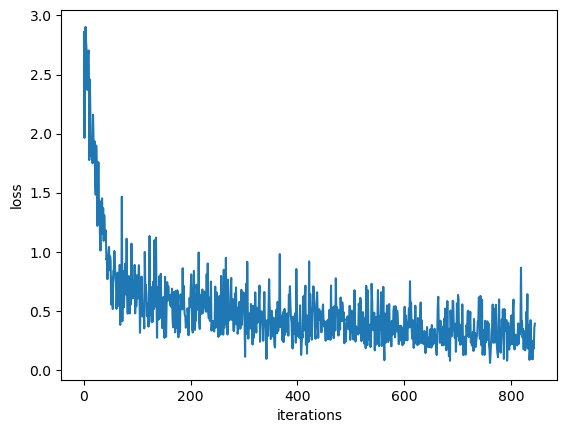

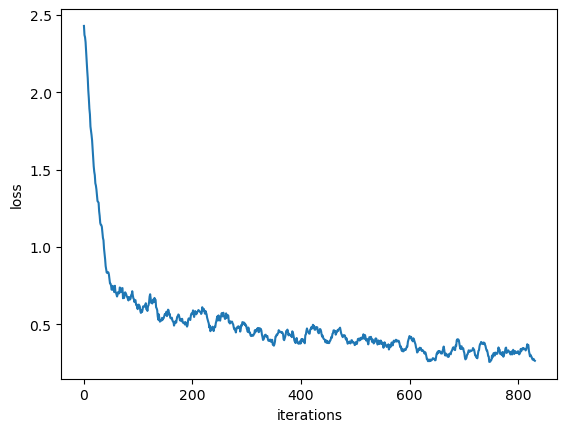

In [30]:
# 超参数
batch_size = 32  # 批处理大小
epochs = 3  # 训练次数
# vector_type = 'last_four_layers_first_token_max_pool'  # 向量表示类型
vector_type = 'textcnn'  # 向量表示类型
classifier_dropout = 0.5  # dropout层参数
learning_rate = 3e-5  # 学习率
warmup = 0.05  # 学习率预热步数的比例
epsilon = 0.2  # 对抗训练因子
r_drop = False  # 是否启用R-Drop方法
alpha = 4  # R-Drop参数
verbose = True  # 是否打印日志
validation = True  # 是否在验证集上进行验证

# 设置随机数种子
seed_torch(6666)

model = train(encoded_data=encoded_train,
              labels=torch.tensor(train_labels).to(device),
              batch_size=batch_size,
              vector_type=vector_type,
              classifier_dropout=classifier_dropout,
              learning_rate=learning_rate,
              epochs=epochs,
              warmup=warmup,
              encoded_val=encoded_dev,
              val_labels=dev_labels,
              epsilon=epsilon,
              r_drop=r_drop,
              alpha=alpha,
              verbose=verbose,
              validation=validation)

## 评估模型

In [31]:
predictions = predict(model, encoded_dev)
print(accuracy_score(dev_labels, predictions))

0.7875


### 交叉验证

In [32]:
from sklearn.model_selection import KFold, StratifiedKFold

# 进行K折交叉验证进行模型评估
def cross_validation(k, all_data, all_labels):
    kf = KFold(n_splits=k, shuffle=True, random_state = 42)

    accuracy_list = []
    for train_index, valid_index in kf.split(all_labels):
        # print(train_index)
        train_data, val_data = [all_data[i] for i in train_index], [all_data[i] for i in valid_index]
        train_labels, val_labels = [all_labels[i] for i in train_index], [all_labels[i] for i in valid_index]

        encoded_train = tokenize(train_data)
        encoded_val = tokenize(val_data)

        model = train(encoded_data=encoded_train,
                      labels=torch.tensor(train_labels).to(device),
                      batch_size=batch_size,
                      vector_type=vector_type,
                      classifier_dropout=classifier_dropout,
                      learning_rate=learning_rate,
                      epochs=epochs,
                      warmup=warmup,
                      encoded_val=encoded_val,
                      val_labels=val_labels,
                      epsilon=epsilon,
                      r_drop=r_drop,
                      alpha=alpha,
                      verbose=False,
                      validation=True)

        predictions = predict(model, encoded_val)
        accuracy_list.append(accuracy_score(val_labels, predictions))

    print(f'accuracy_list: {accuracy_list}')
    print(f'avg_accuracy: {np.mean(accuracy_list)}')

In [31]:
# 合并数据集
all_data = train_data + dev_data
all_labels = train_labels + dev_labels

k = 5  # 交叉验证折数

# 设置随机数种子
torch.manual_seed(42)

# 超参数
batch_size = 32
epochs = 3
vector_type = 'textcnn'
classifier_dropout = 0.5
learning_rate = 3e-5
warmup = 0.1
epsilon = 0.2
r_drop = False
alpha = 2

cross_validation(k, all_data, all_labels)

总训练步数: 825
epoch 0, val_acc: 0.8322727272727273
epoch 1, val_acc: 0.8418181818181818
epoch 2, val_acc: 0.8454545454545455
总训练步数: 825
epoch 0, val_acc: 0.84
epoch 1, val_acc: 0.8518181818181818
epoch 2, val_acc: 0.8522727272727273
总训练步数: 825
epoch 0, val_acc: 0.8218181818181818
epoch 1, val_acc: 0.8368181818181818
epoch 2, val_acc: 0.8386363636363636
总训练步数: 825
epoch 0, val_acc: 0.8368181818181818
epoch 1, val_acc: 0.8518181818181818
epoch 2, val_acc: 0.8536363636363636
总训练步数: 825
epoch 0, val_acc: 0.8231818181818182
epoch 1, val_acc: 0.8427272727272728
epoch 2, val_acc: 0.8377272727272728
accuracy_list: [0.8454545454545455, 0.8522727272727273, 0.8386363636363636, 0.8536363636363636, 0.8377272727272728]
avg_accuracy: 0.8455454545454545


## 完整数据集训练模型

### 使用 Yes/r_drop textcnn No/fgm 

In [35]:
# 3:33 补加 L
# 合并数据集
all_data = train_data + dev_data
all_labels = train_labels + dev_labels

encoded_all = tokenize(all_data)

# 超参数
batch_size = 32
epochs = 3
vector_type = 'textcnn'
classifier_dropout = 0.1
learning_rate = 5e-5
warmup = 0.05
r_drop = True
alpha = 4

# 设置随机数种子
torch.manual_seed(41)

model = train(encoded_data=encoded_all,
              labels=torch.tensor(all_labels).to(device),
              batch_size=batch_size,
              vector_type=vector_type,
              classifier_dropout=classifier_dropout,
              learning_rate=learning_rate,
              epochs=epochs,
              r_drop=r_drop,
              alpha=alpha)

#### 保存模型

In [ ]:
torch.save(model, 'model/bert_model_(textcnn_Yesr-drop_Nofgm).pth')

predictions = predict(model, encoded_dev)
print(accuracy_score(dev_labels, predictions))

0.9605


### 对比实验 dropout 

总训练步数: 1032
epoch 0, iterations 34, loss: 1.0116602182388306
epoch 0, iterations 68, loss: 1.0210925340652466
epoch 0, iterations 102, loss: 0.7502604126930237
epoch 0, iterations 136, loss: 0.6450334191322327
epoch 0, iterations 170, loss: 0.5350735783576965
epoch 0, iterations 204, loss: 0.49049386382102966
epoch 0, iterations 238, loss: 0.6910581588745117
epoch 0, iterations 272, loss: 0.46719616651535034
epoch 0, iterations 306, loss: 0.7636473774909973
epoch 0, iterations 340, loss: 0.3809928596019745
epoch 1, iterations 34, loss: 0.16825851798057556
epoch 1, iterations 68, loss: 0.24442389607429504
epoch 1, iterations 102, loss: 0.26127132773399353
epoch 1, iterations 136, loss: 0.376347154378891
epoch 1, iterations 170, loss: 0.2606383264064789
epoch 1, iterations 204, loss: 0.16984938085079193
epoch 1, iterations 238, loss: 0.1917228400707245
epoch 1, iterations 272, loss: 0.3129030168056488
epoch 1, iterations 306, loss: 0.15447236597537994
epoch 1, iterations 340, loss: 0.146

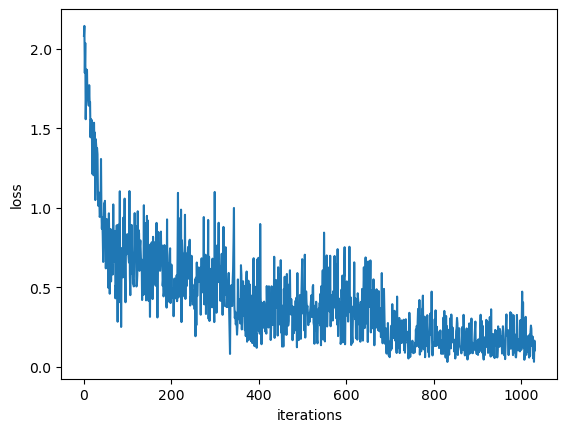

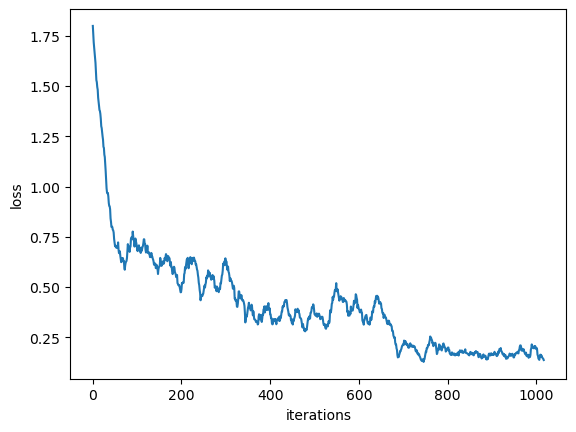

In [33]:
# 3:33 补加 L
# 合并数据集
all_data = train_data + dev_data
all_labels = train_labels + dev_labels

encoded_all = tokenize(all_data)

# 超参数
batch_size = 32
epochs = 3
vector_type = 'textcnn'
classifier_dropout = 0.1
learning_rate = 5e-5
warmup = 0.05
r_drop = False
alpha = 4

# 设置随机数种子
torch.manual_seed(41)

model = train(encoded_data=encoded_all,
              labels=torch.tensor(all_labels).to(device),
              batch_size=batch_size,
              vector_type=vector_type,
              classifier_dropout=classifier_dropout,
              learning_rate=learning_rate,
              epochs=epochs,
              r_drop=r_drop,
              alpha=alpha)

In [34]:
torch.save(model, 'model/bert_model_(textcnn_False-drop_Nofgm).pth')

predictions = predict(model, encoded_dev)
print(accuracy_score(dev_labels, predictions))

0.9645


### 使用 No/r_drop lstm No/fgm 

总训练步数: 1032
epoch 0, iterations 34, loss: 1.2832955121994019
epoch 0, iterations 68, loss: 0.936855673789978
epoch 0, iterations 102, loss: 0.7052280306816101
epoch 0, iterations 136, loss: 0.5732476711273193
epoch 0, iterations 170, loss: 0.4497649371623993
epoch 0, iterations 204, loss: 0.40977033972740173
epoch 0, iterations 238, loss: 0.8096013069152832
epoch 0, iterations 272, loss: 0.47839832305908203
epoch 0, iterations 306, loss: 0.6018223762512207
epoch 0, iterations 340, loss: 0.40216901898384094
epoch 1, iterations 34, loss: 0.26973310112953186
epoch 1, iterations 68, loss: 0.2604120969772339
epoch 1, iterations 102, loss: 0.3674578070640564
epoch 1, iterations 136, loss: 0.46156254410743713
epoch 1, iterations 170, loss: 0.25500985980033875
epoch 1, iterations 204, loss: 0.23132313787937164
epoch 1, iterations 238, loss: 0.2416726052761078
epoch 1, iterations 272, loss: 0.6439988017082214
epoch 1, iterations 306, loss: 0.2027919739484787
epoch 1, iterations 340, loss: 0.262

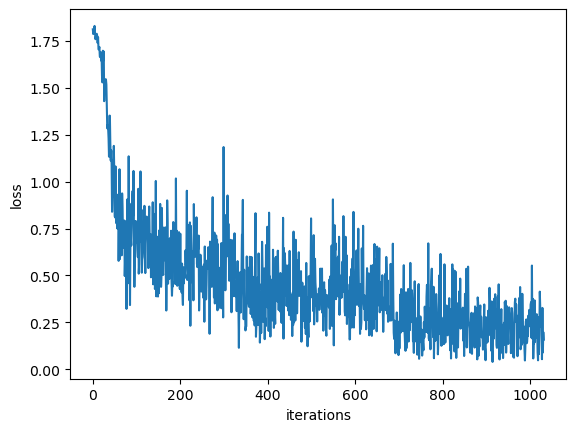

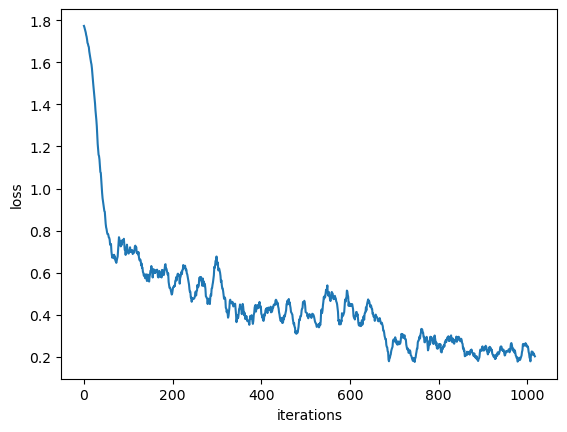

In [ ]:
# L
encoded_all = tokenize(all_data)

# 超参数
batch_size = 32
epochs = 3
vector_type = 'last_layer_lstm'
classifier_dropout = 0.1
learning_rate = 5e-5
warmup = 0.05
r_drop = False
alpha = 4

# 设置随机数种子
torch.manual_seed(41)

model = train(encoded_data=encoded_all,
              labels=torch.tensor(all_labels).to(device),
              batch_size=batch_size,
              vector_type=vector_type,
              classifier_dropout=classifier_dropout,
              learning_rate=learning_rate,
              epochs=epochs,
              r_drop=r_drop,
              alpha=alpha)

#### 保存模型

In [ ]:
torch.save(model, 'model/bert_model_(lstm_Nor-drop_Nofgm).pth')

predictions = predict(model, encoded_dev)
print(accuracy_score(dev_labels, predictions))

0.93


### 使用FGM对抗训练方法 （弃用）

总训练步数: 1032
epoch 0, iterations 34, loss: 0.8608933091163635
epoch 0, iterations 68, loss: 0.976092517375946
epoch 0, iterations 102, loss: 0.6978705525398254
epoch 0, iterations 136, loss: 0.627447783946991
epoch 0, iterations 170, loss: 0.5135840177536011
epoch 0, iterations 204, loss: 0.40264248847961426
epoch 0, iterations 238, loss: 0.7768768668174744
epoch 0, iterations 272, loss: 0.4838730990886688
epoch 0, iterations 306, loss: 0.5637223124504089
epoch 0, iterations 340, loss: 0.37291744351387024
epoch 1, iterations 34, loss: 0.21238566935062408
epoch 1, iterations 68, loss: 0.22815442085266113
epoch 1, iterations 102, loss: 0.3673079311847687
epoch 1, iterations 136, loss: 0.48824843764305115
epoch 1, iterations 170, loss: 0.29091984033584595
epoch 1, iterations 204, loss: 0.22226274013519287
epoch 1, iterations 238, loss: 0.29888761043548584
epoch 1, iterations 272, loss: 0.48667508363723755
epoch 1, iterations 306, loss: 0.2457752823829651
epoch 1, iterations 340, loss: 0.24

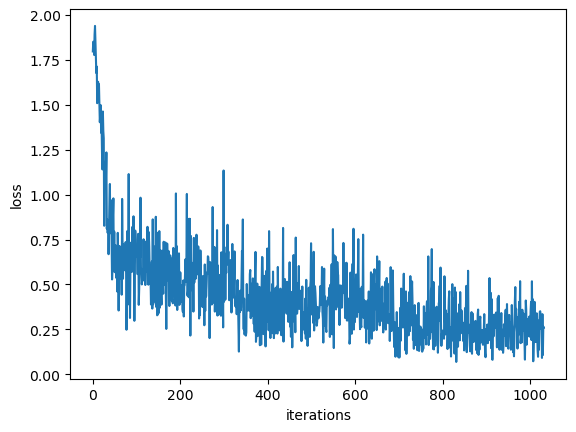

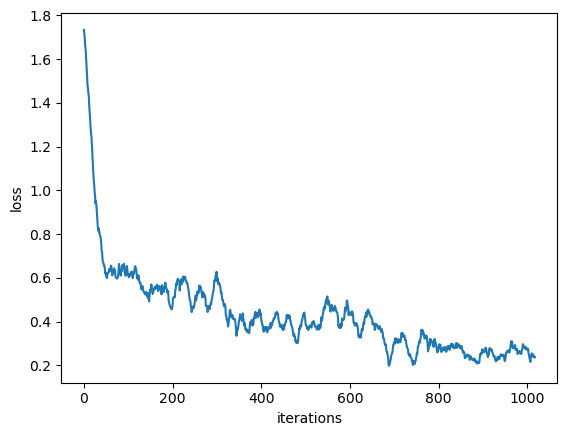

In [33]:
all_data = train_data + dev_data
all_labels = train_labels + dev_labels
encoded_all = tokenize(all_data)

# 超参数
num_labels = 6
batch_size = 32
epochs = 3
vector_type = 'last_four_layers_first_token_max_pool'
classifier_dropout = 0
learning_rate = 5e-5
warmup = 0.05
epsilon = 0.2
r_drop = False

# 设置随机数种子
torch.manual_seed(41)

model = train(encoded_data=encoded_all,
              labels=torch.tensor(all_labels).to(device),
              batch_size=batch_size,
              vector_type=vector_type,
              classifier_dropout=classifier_dropout,
              learning_rate=learning_rate,
              epochs=epochs,
              warmup=warmup,
              r_drop=r_drop,
              epsilon=epsilon)

#### 保存模型

In [35]:
torch.save(model, 'model/bert_model_FGM-dversarial.pth')

predictions = predict(model, encoded_dev)
print(accuracy_score(dev_labels, predictions))

0.9005


## 测试集预测 （用于提交推理）

In [36]:
def submit(predictions):
    question = pd.read_csv('data/test.txt', delimiter='\t', header=None, names=['question', 'label'])['question'].tolist()
    # 生成提交文件
    submission_df = pd.DataFrame({'question': question, 'label': predictions})
    submission_df.to_csv('result/submission.txt', sep='\t', index=False, header=False)

In [37]:
test_predictions = predict(model, encoded_test)
submit(test_predictions)

## 模型集成

### Averaging集成

In [3]:
def averaging(model_list, model_weight):
    # 准备数据加载器
    batch_size = 128
    dataset = TensorDataset(encoded_test['input_ids'],
                            encoded_test['token_type_ids'],
                            encoded_test['attention_mask'])
    loader = DataLoader(dataset, batch_size=batch_size)

    # 存储预测标签
    predictions = []

    with torch.no_grad():  # 无需计算梯度
        for inputs_ids, token_type_ids, attention_mask in loader:
            inputs = {'input_ids': inputs_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask, 'dropout': False}
            # 将各模型预测结果相加
            pred_vec = torch.zeros([inputs_ids.shape[0], 6]).to(device)
            for model, weight in zip(model_list, model_weight):
                output = model(**inputs)
                pred_vec += output * weight
            # 转换为预测结果
            pred_labels = torch.argmax(pred_vec, dim=1)
            # print(pred_labels)
            predictions.extend(pred_labels.cpu().numpy())

    return predictions

In [ ]:
# 加载模型

model1 = torch.load('model/bert_model_(textcnn_Yesr-drop_Nofgm).pth') # 0.96
model2 = torch.load('model/bert_model_(lstm_Nor-drop_Nofgm).pth') # 0.93


model_list = [model1, model2]  # 模型列表
model_weight = [1.2, 0.9]  # 模型权重

combined_predictions = averaging(model_list, model_weight)
submit(combined_predictions)

### Stacking集成

In [ ]:
from sklearn.model_selection import KFold

def get_logits(model, encoded_data, batch_size=1024):  # 获取模型输出
    # 准备数据加载器
    dataset = TensorDataset(encoded_data['input_ids'],
                            encoded_data['token_type_ids'],
                            encoded_data['attention_mask'])
    loader = DataLoader(dataset, batch_size=batch_size)

    # 存储模型输出
    logits = []

    with torch.no_grad():  # 无需计算梯度
        for inputs_ids, token_type_ids, attention_mask in loader:
            inputs = {'input_ids': inputs_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask, 'dropout': False}
            output = model(**inputs)
            logits.extend(output.cpu().numpy())

    return np.array(logits)

#### 第一层训练

In [ ]:
# stacking第一层训练：训练基学习器得到元学习器的训练集和测试集的输入
def stacking_base_train(kf, model_param, encoded_all, all_labels, encoded_test):
    val_output = [[] for _ in range(len(all_labels))]  # 存储单个基模型对训练集的预测
    test_output = []  # 存储单个基模型对测试集的预测
    # 对单个基模型进行k折交叉验证的训练
    for train_index, valid_index in kf.split(all_labels, all_labels):
        encoded_train = {'input_ids': torch.index_select(encoded_all['input_ids'], 0, torch.tensor(train_index).to(device)),
                         'token_type_ids': torch.index_select(encoded_all['token_type_ids'], 0, torch.tensor(train_index).to(device)),
                         'attention_mask': torch.index_select(encoded_all['attention_mask'], 0, torch.tensor(train_index).to(device))}
        encoded_val = {'input_ids': torch.index_select(encoded_all['input_ids'], 0, torch.tensor(valid_index).to(device)),
                         'token_type_ids': torch.index_select(encoded_all['token_type_ids'], 0, torch.tensor(valid_index).to(device)),
                         'attention_mask': torch.index_select(encoded_all['attention_mask'], 0, torch.tensor(valid_index).to(device))}
        train_labels, val_labels = [all_labels[i] for i in train_index], [all_labels[i] for i in valid_index]

        model_param['encoded_data'] = encoded_train
        model_param['labels'] = torch.tensor(train_labels).to(device)
        model_param['encoded_val'] = encoded_val
        model_param['val_labels'] = val_labels

        model = train(**model_param)

        logits_val = get_logits(model, encoded_val) # 单模型对这一折的验证集的预测输出
        for i, val_i in enumerate(valid_index):
            val_output[val_i] = logits_val[i]
        logits_test = get_logits(model, encoded_test)  # 单模型对测试集的预测输出
        test_output.append(logits_test)

    val_output = np.array(val_output)
    test_output = np.mean(test_output, axis=0)  # averaging得到测试集的预测输出

    return val_output, test_output

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
# 合并数据集
all_data = train_data + dev_data
all_labels = train_labels + dev_labels
# all_data = aeda_train_data + aeda_dev_data
# all_labels = aeda_train_labels + aeda_dev_labels

encoded_all = tokenize(all_data)

base_model_params = [    # 基模型参数列表
                        {
                            'batch_size': 32,
                            'epochs': 2,
                            'vector_type': 'last_four_layers_lstm',
                            'classifier_dropout': 0.2,
                            'learning_rate': 3e-5,
                            'warmup': 0.1,
                            'epsilon': 0.2,
                            'r_drop': False,
                            'verbose': False,
                            'validation': True
                         },
                         {
                            'batch_size': 32,
                            'epochs': 3,
                            'vector_type': 'last_layer_lstm',
                            'classifier_dropout': 0.2,
                            'learning_rate': 3e-5,
                            'warmup': 0.1,
                            'epsilon': 0.2,
                            'r_drop': False,
                            # 'alpha': 2,
                            'verbose': False,
                            'validation': True
                         },
                         {
                            'batch_size': 32,
                            'epochs': 3,
                            'vector_type': 'textcnn',
                            'classifier_dropout': 0.5,
                            'learning_rate': 3e-5,
                            'warmup': 0.1,
                            'epsilon': 0.2,
                            'r_drop': False,
                            'verbose': False,
                            'validation': True
                         },

                    ]

# 设置随机数种子
torch.manual_seed(42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

base_model_train = []  # 存储所有基模型对训练集的预测
base_model_test = []   # 存储所有基模型对测试集的预测
for i, model_param in enumerate(base_model_params):
    print(f'Model{i+1}: ')
    val_output, test_output = stacking_base_train(kf, model_param, encoded_all, all_labels, encoded_test)
    base_model_train.append(val_output)
    base_model_test.append(test_output)

base_model_train = np.concatenate(base_model_train, axis=1)  # 将各基模型的输出拼接成一个向量
base_model_test = np.concatenate(base_model_test, axis=1)

Model1: 
总训练步数: 550
epoch 0, val_acc: 0.8327272727272728
epoch 1, val_acc: 0.8409090909090909
总训练步数: 550
epoch 0, val_acc: 0.8436363636363636
epoch 1, val_acc: 0.8513636363636363
总训练步数: 550
epoch 0, val_acc: 0.8272727272727273
epoch 1, val_acc: 0.8427272727272728
总训练步数: 550
epoch 0, val_acc: 0.8372727272727273
epoch 1, val_acc: 0.8518181818181818
总训练步数: 550
epoch 0, val_acc: 0.8359090909090909
epoch 1, val_acc: 0.8454545454545455
Model2: 
总训练步数: 825
epoch 0, val_acc: 0.835
epoch 1, val_acc: 0.8459090909090909
epoch 2, val_acc: 0.8536363636363636
总训练步数: 825
epoch 0, val_acc: 0.8372727272727273
epoch 1, val_acc: 0.8518181818181818
epoch 2, val_acc: 0.850909090909091
总训练步数: 825
epoch 0, val_acc: 0.8381818181818181
epoch 1, val_acc: 0.8395454545454546
epoch 2, val_acc: 0.8431818181818181
总训练步数: 825
epoch 0, val_acc: 0.8345454545454546
epoch 1, val_acc: 0.8495454545454545
epoch 2, val_acc: 0.850909090909091
总训练步数: 825
epoch 0, val_acc: 0.8322727272727273
epoch 1, val_acc: 0.8377272727272728

In [ ]:
base_model_train.shape

(11000, 18)

#### 第二层训练

In [ ]:
from sklearn.linear_model import LogisticRegression
# stacking第二层训练：训练元学习器并得到测试集的预测结果
def stacking_meta_train(base_model_train, train_labels, base_model_test):
    meta_model = LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs', max_iter=1000)  # 使用逻辑回归模型作为元学习器
    meta_model.fit(base_model_train, train_labels)
    predictions = meta_model.predict(base_model_test)
    return predictions

In [ ]:
predictions = stacking_meta_train(base_model_train, all_labels, base_model_test)
submit(predictions)